<a href="https://colab.research.google.com/github/Miharada/RealTime-Trash-Detection/blob/main/Trash_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Additional Lib

In [ ]:
!pip install -U split_folders
!pip install --upgrade keras keras-applications

     |████████████████████████████████| 50 kB 5.1 MB/s 


# Import Lib

In [ ]:

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.applications.vgg16 import preprocess_input
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import densenet
from tensorflow.keras.optimizers import Adam
# from keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import splitfolders

# Data Preparing

In [ ]:
data_path = "/content/drive/MyDrive/Lomba/Compfest 2021/Garbage Dataset 1.zip"

In [ ]:
!cp "/content/drive/MyDrive/Lomba/Compfest 2021/Garbage Dataset 1.zip" "/content/"

In [ ]:
!unzip "/content/Garbage Dataset 1.zip"

# Data Split

In [ ]:
splitfolders.ratio("/content/Garbage Dataset 1", output="output", seed=1337, ratio=(0.6, 0.4))

Copying files: 2527 files [00:00, 4234.16 files/s]


In [ ]:
# setting the path and the labels list for classification of targets on the basis in human understandable form

train_dir = os.path.join('/content/output/train')
test_dir = os.path.join('/content/output/val')

labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# checking the size of data available to us for training out model

for label in labels:
    directory = os.path.join(train_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

Images of label "cardboard":	 241
Images of label "glass":	 300
Images of label "metal":	 246
Images of label "paper":	 356
Images of label "plastic":	 289
Images of label "trash":	 82


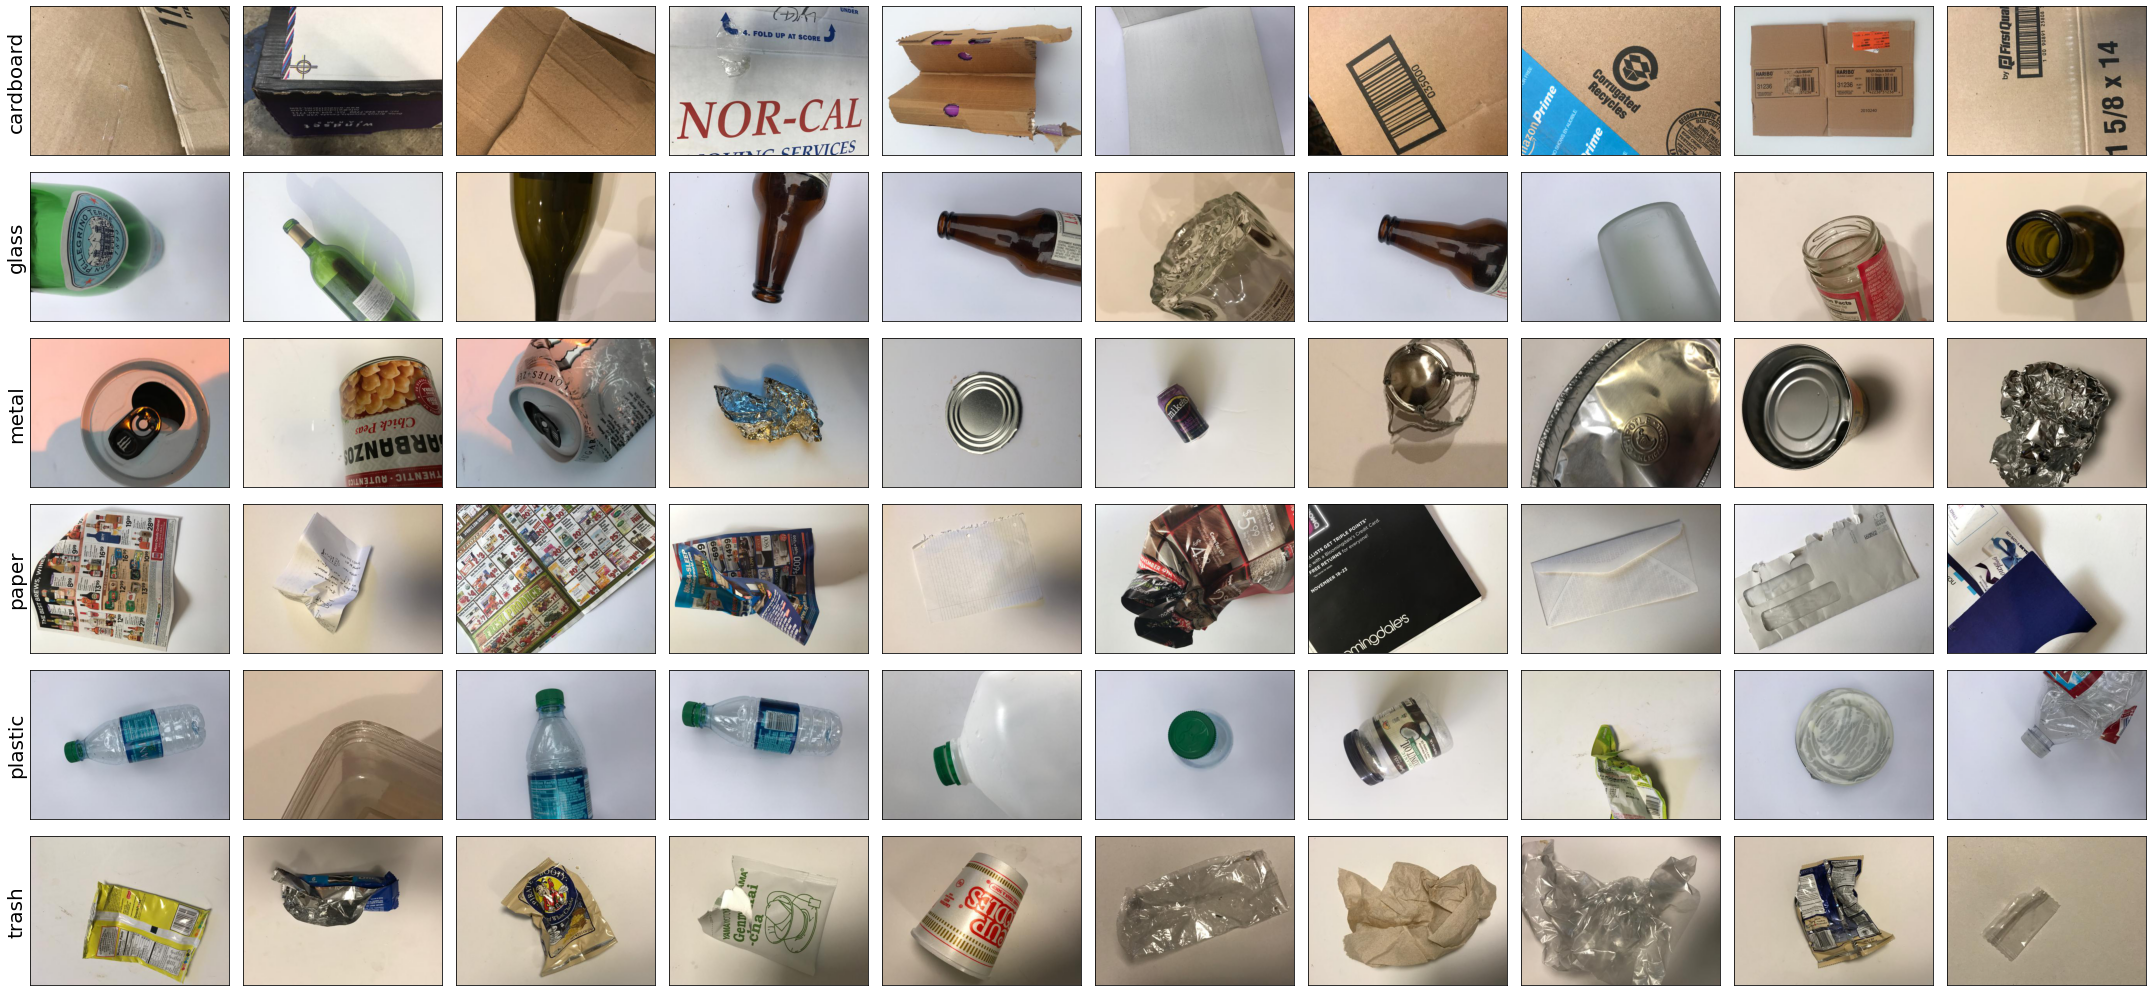

In [ ]:
# plotting images of different review for understanding the dataset

plt.figure(figsize=(30,14))

for i in range(6):
    directory = os.path.join(test_dir, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

In [ ]:
# checking size of individual image

directory = os.path.join(train_dir, 'cardboard')
path = os.path.join(directory, os.listdir(directory)[0])
image = mpimg.imread(path)
image.shape

(384, 512, 3)

# DenseNet121 Model

In [ ]:
EPOCHS = 50
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenets = densenet.DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenets(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(6,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_densenet()

29097984/29084464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
______________________________________________________________

In [ ]:
# creating generators for combining data and increasing the gainable insights by slightly modifying the images in the dataset

train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                                   rotation_range=15,zoom_range=0.1,
                                   width_shift_range=0.15,height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255., 
                                   validation_split=0.2,
                                   preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(64, 64), 
                                                    batch_size=32, class_mode='categorical', 
                                                    subset='training')
validation_generator = test_datagen.flow_from_directory(test_dir, target_size=(64, 64), 
                                                         batch_size=32, class_mode='categorical')

Found 1213 images belonging to 6 classes.
Found 1013 images belonging to 6 classes.


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, epochs=EPOCHS, 
                    verbose=1, validation_data=validation_generator, 
                    callbacks=[annealer, checkpoint])

Epoch 1/50
38/38 [==============================] - 61s 445ms/step - loss: 2.8380 - accuracy: 0.2135 - val_loss: 2.5264 - val_accuracy: 0.1885

Epoch 00001: val_loss improved from inf to 2.52636, saving model to model.h5
Epoch 2/50
38/38 [==============================] - 11s 289ms/step - loss: 2.2478 - accuracy: 0.3190 - val_loss: 2.0763 - val_accuracy: 0.2705

Epoch 00002: val_loss improved from 2.52636 to 2.07632, saving model to model.h5
Epoch 3/50
38/38 [==============================] - 11s 289ms/step - loss: 1.8821 - accuracy: 0.4188 - val_loss: 1.7846 - val_accuracy: 0.4413

Epoch 00003: val_loss improved from 2.07632 to 1.78464, saving model to model.h5
Epoch 4/50
38/38 [==============================] - 11s 288ms/step - loss: 1.6103 - accuracy: 0.5004 - val_loss: 1.4585 - val_accuracy: 0.5252

Epoch 00004: val_loss improved from 1.78464 to 1.45849, saving model to model.h5
Epoch 5/50
38/38 [==============================] - 11s 292ms/step - loss: 1.4182 - accuracy: 0.5334 - v